## Некоторые практические задания из курса "Продвинутый SQL" (оконные функции, рамки, ранжирование)

### Ниже представлена ER-диаграммa базы и краткое описание 

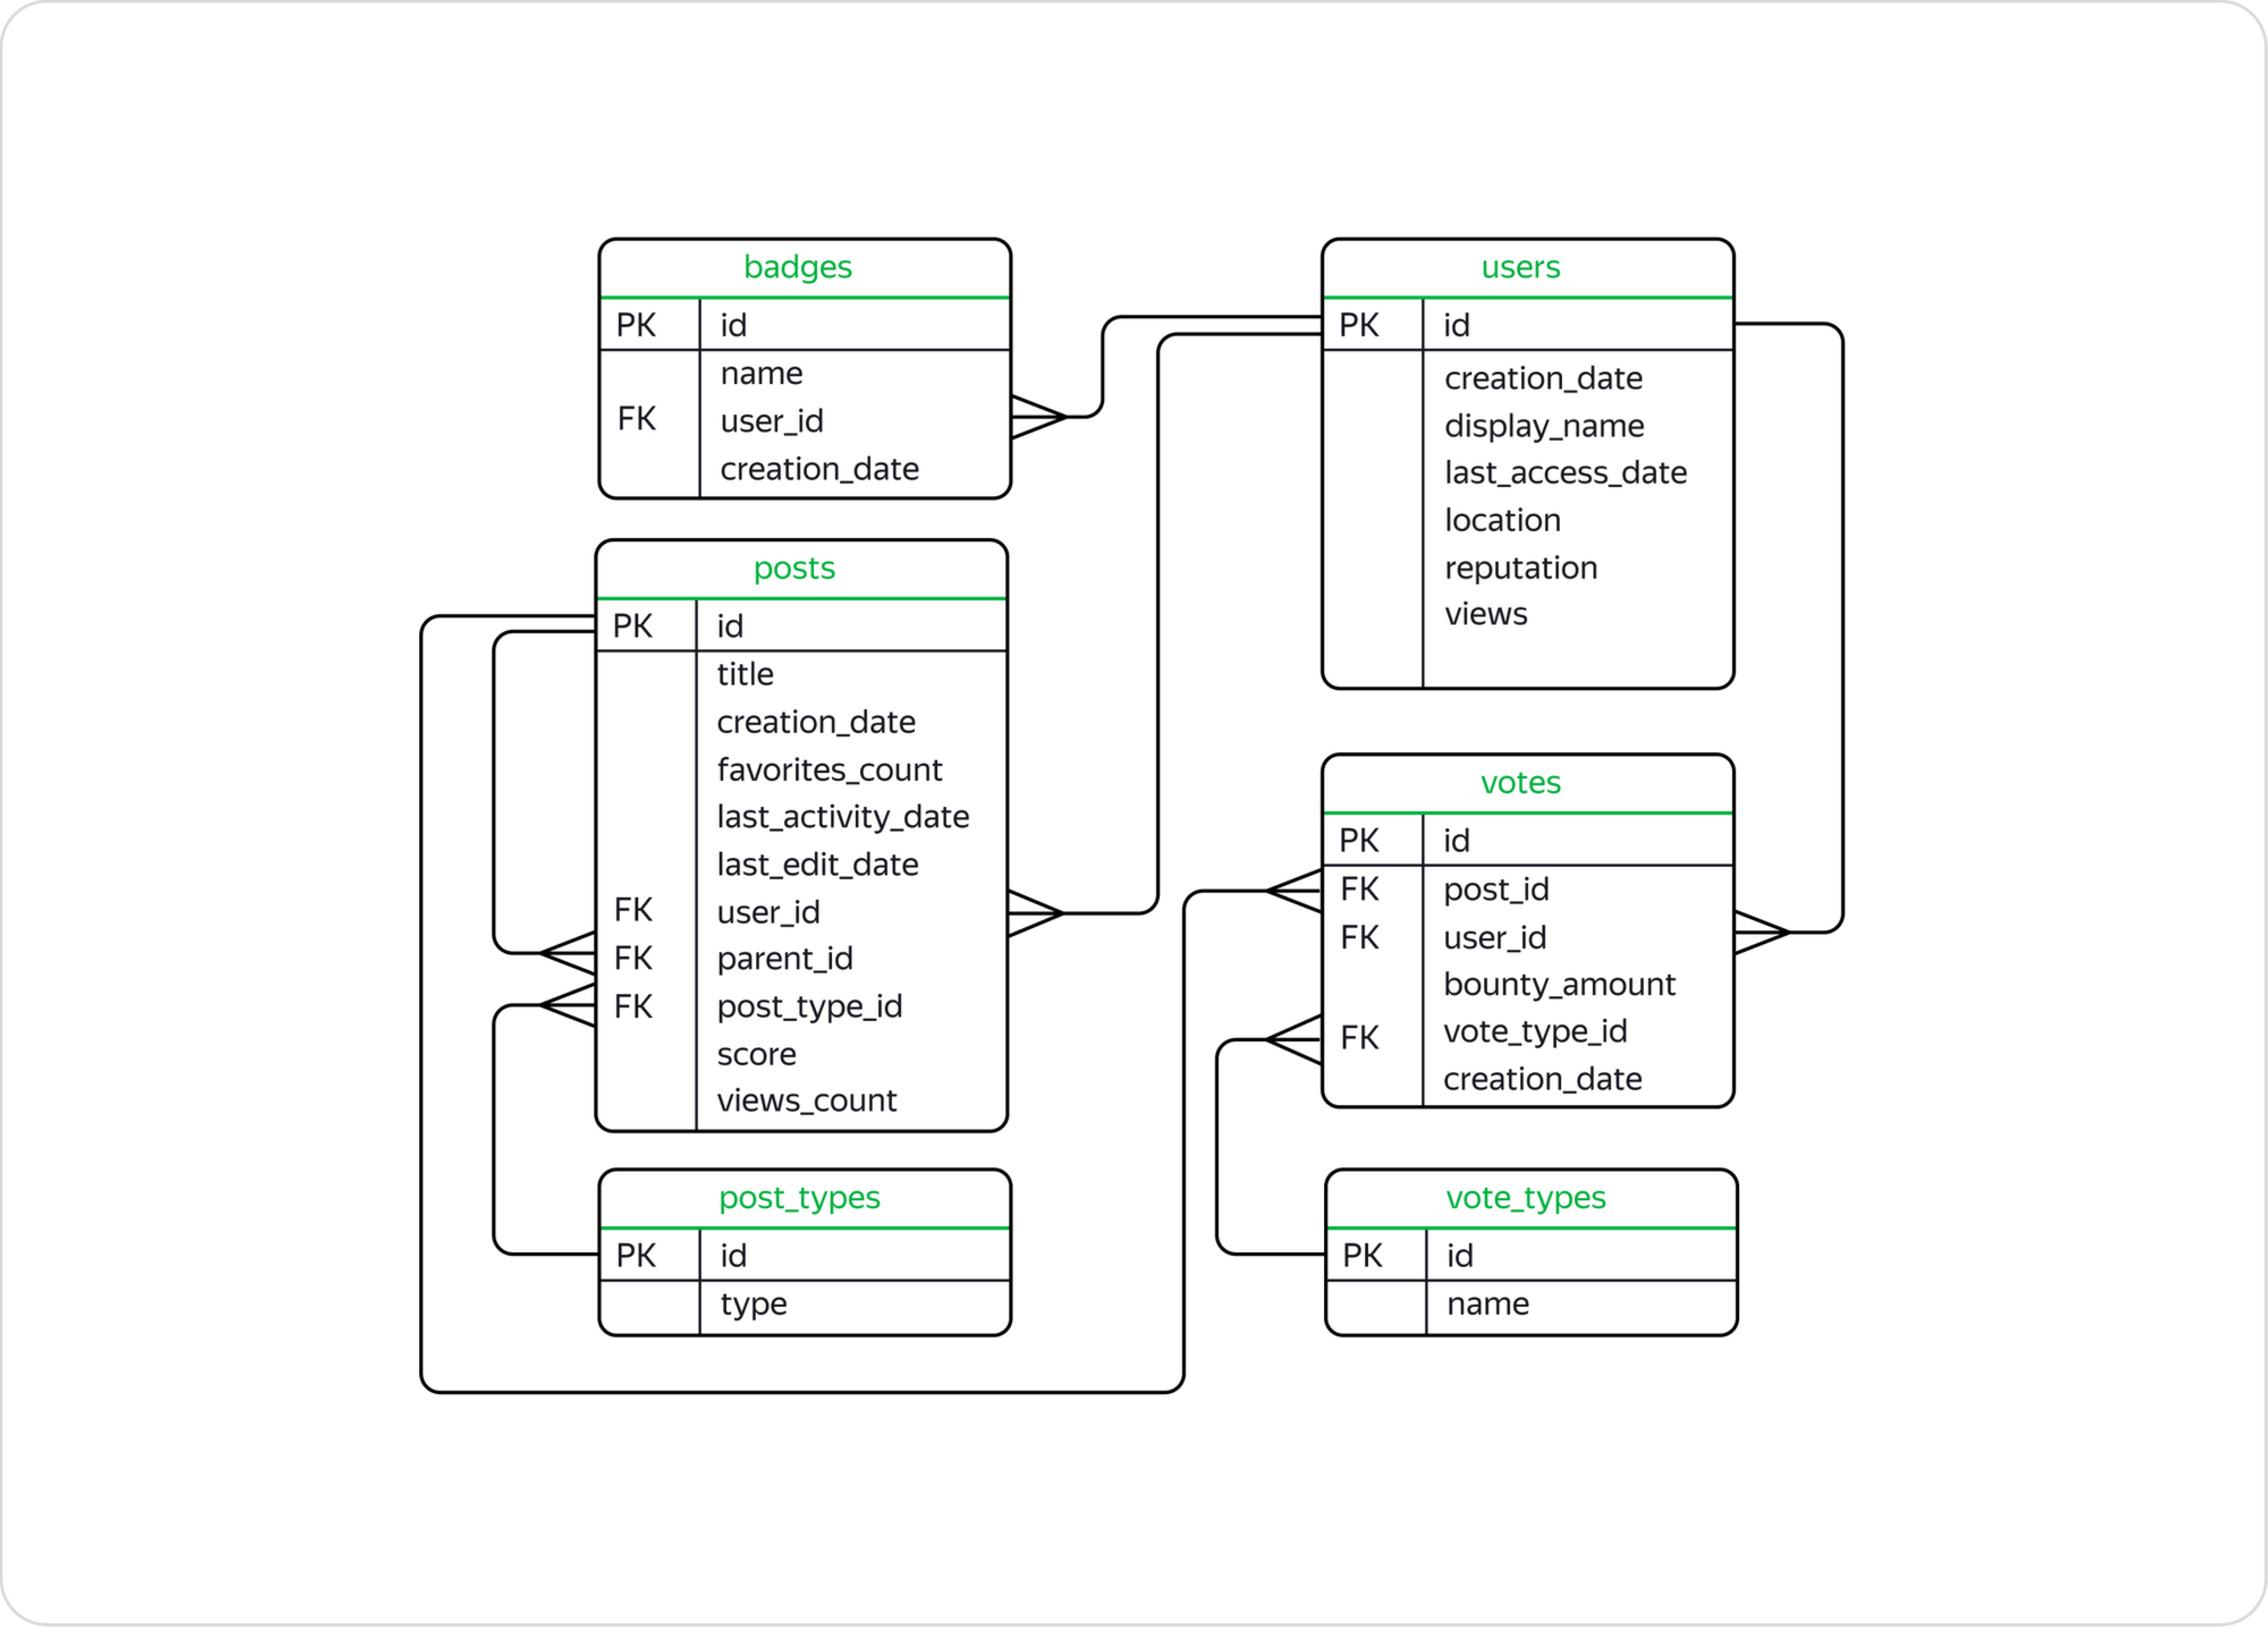

### Таблица stackoverflow.posts
  

|Поле|Описание|
|:--:|:--------:|
|id|	Идентификатор поста, первичный ключ таблицы|
|title|	Заголовок поста|
|creation_date|	Дата создания поста|
|favorites_count|	Число, которое показывает, сколько раз пост добавили в «Закладки»|
|last_activity_date|	Дата последнего действия в посте, например комментария|
|last_edit_date|	Дата последнего изменения поста|
|user_id|	Идентификатор пользователя, который создал пост, внешний ключ к таблице users|
|parent_id|	Если пост написали в ответ на другую публикацию, в это поле попадёт идентификатор поста с вопросом|
|post_type_id|	Идентификатор типа поста, внешний ключ к таблице post_types|
|score|	Количество очков, которое набрал пост|
|views_count|	Количество просмотров|


### Таблица stackoverflow.badges

|Поле|	Описание|
|:--:|:--------:|
|id|	Идентификатор значка, первичный ключ таблицы|
|name|	Название значка|
|user_id|	Идентификатор пользователя, которому присвоили значок, внешний ключ, отсылающий к таблице users|
|creation_date|	Дата присвоения значка|

### Таблица stackoverflow.post_types
|Поле|	Описание|
|:--:|:--------:|
|id|	Идентификатор поста, первичный ключ таблицы|
|type|	Тип поста|

### Таблица stackoverflow.users
|Поле|	Описание|
|:--:|:--------:|
|id|	Идентификатор пользователя, первичный ключ таблицы|
|creation_date|	Дата регистрации пользователя|
|display_name|	Имя пользователя|
|last_access_date|	Дата последнего входа|
|location|	Местоположение|
|reputation|	Очки репутации, которые получают за хорошие вопросы и полезные ответы|
|views|	Число просмотров профиля пользователя|

### Таблица stackoverflow.vote_types
|Поле|	Описание|
|:--:|:--------:|
|id|	Идентификатор типа голоса, первичный ключ|
|name|	Название метки|

### Таблица stackoverflow.votes
|Поле|	Описание|
|:--:|:--------:|
|id|	Идентификатор голоса, первичный ключ|
|post_id|	Идентификатор поста, внешний ключ к таблице posts|
|user_id|	Идентификатор пользователя, который поставил посту голос, внешний ключ к таблице users|
|bounty_amount|	Сумма вознаграждения, которое назначают, чтобы привлечь внимание к посту|
|vote_type_id|	Идентификатор типа голоса, внешний ключ к таблице vote_types|
|creation_date|	Дата назначения голоса|


### Задачи

**1.
Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».**

    SELECT COUNT(distinct title)
    FROM stackoverflow.posts as aa
    join stackoverflow.post_types as bb on aa.post_type_id = bb.id
    where bb.type = 'Question' AND aa.score > 300 OR aa.favorites_count >= 100


**2.
Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.**

     with Templ AS (select count(title),  
    creation_date
    from (SELECT title,
     aa.creation_date::date
    FROM stackoverflow.posts as aa
    join stackoverflow.post_types as bb on aa.post_type_id = bb.id
    where bb.type = 'Question' AND aa.creation_date::date between '01.11.2008' and '18.11.2008') as t_t
    group by t_t.creation_date)
    select round(avg(count), 0)
    from Templ

**3.
Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?** 

    select count(*)
    from (select distinct count(id) over (partition by post_id) as ppp,
    post_id
    from stackoverflow.votes
    where post_id in (select distinct(pss.id)
    from stackoverflow.users ass
    join stackoverflow.posts pss on ass.id = pss.user_id
    where ass.display_name = 'Joel Coehoorn')) as templ 

**4.
Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.**  

    select distinct user_id,
        count(post_id) over (partition by user_id)
    from (select vv.post_id,
        vv.user_id
    from stackoverflow.votes vv
    join stackoverflow.vote_types vt on vv.vote_type_id = vt.id
    where vt.name = 'Close') as tb
    order by count desc, user_id desc
    limit 10

**5.
Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно.
Отобразите несколько полей:
идентификатор пользователя;
число значков;
место в рейтинге — чем больше значков, тем выше рейтинг.
Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя**  

    select user_id, b_num,
    dense_rank() over (order by b_num desc)
    from (select distinct user_id,
    count(id) over (partition by user_id) as b_num
    from stackoverflow.badges
    where creation_date::date between '2008-11-15' and '2008-12-15'
    order by b_num desc, user_id
    limit 19) as t_t
    limit 10 

**6.
Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:
пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
пользователям с числом просмотров меньше 100 — группу 3.
Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу.**  

    select id, views,
    case
    when views < 100 then 3
    when views >= 100 and views < 350 then 2
    when views >= 350 then 1
    end
    from stackoverflow.users
    where location like '%United States%' and views != 0

**7.
Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
номер дня;
число пользователей, зарегистрированных в этот день;
сумму пользователей с накоплением.**

    select day_num, users_amount,
    sum(users_amount) over (order by day_num)
    from (select distinct extract(day from creation_date::date) as day_num,
    count(id) over (partition by extract(day from creation_date::date)) as users_amount
    from stackoverflow.users
    where extract(year from creation_date::date) = 2008 and
    extract(month from creation_date::date) = 11) as t_t

**8.
Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.**  

    select distinct month_c::date,
    sum(views_count) over(partition by month_c )
    from (select date_trunc('month', creation_date::timestamp) as month_c, views_count
    from stackoverflow.posts
    where extract(year from creation_date::timestamp) = 2008) as t_t
    order by sum desc

**9.
Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.**

    with
    jaja as (select distinct u.id, date_trunc('month', ps.creation_date::date)::date, 
    count(ps.id) over (partition by u.id order by date_trunc('month', ps.creation_date::date) desc )
    as amount
    from  stackoverflow.posts ps
    join stackoverflow.users u on ps.user_id = u.id
    where date_trunc('month', u.creation_date) = '2008-09-01' and 
    date_trunc('month', ps.creation_date) = '2008-12-01')
    select distinct date_trunc('month', pss.creation_date::date)::date, 
    count(pss.id) over (partition by date_trunc('month', pss.creation_date::date))
    from stackoverflow.posts pss
    join jaja on pss.user_id = jaja.id
    where amount > 0 and extract(year from pss.creation_date::timestamp) = 2008
    order by 1 desc

**10.
Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.**

    select round(avg(count) )
    from (
    select u.id, 
    count( distinct ps.creation_date::date)
    from stackoverflow.posts ps
    join stackoverflow.users u on ps.user_id = u.id
    where ps.creation_date::date between '2008-12-1' and '2008-12-7'
    group by u.id ) as gogo

**11.
Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:**
- **номер недели;**
- **дата и время последнего поста, опубликованного на этой неделе.**

    with 
    kaka as (select distinct user_id,
    count(id) over (partition by user_id)
    from stackoverflow.posts
    order by count(id) over (partition by user_id) desc
    limit 1) 
    select distinct
    extract('week' from ps.creation_date::date),
    max(ps.creation_date::timestamp) over (order by extract('week' from ps.creation_date::date))
    from stackoverflow.posts ps
    join kaka on ps.user_id = kaka.user_id
    where date_trunc('month', ps.creation_date::date) = '2008-10-01'